In [9]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

import joblib 

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import nltk
from nltk.stem import PorterStemmer
import json

import re
import string

In [10]:
# Stopword Removal
ps = PorterStemmer()
with open('../../Datasets/stopwords-tl.json', 'r') as f:
    stopwords = json.load(f)

# Custom transformer for text preprocessing
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return [' '.join(self.preprocess(text)) for text in X]
    
    def preprocess(self, text):
        # Lowercase Conversion
        lowered = text.lower()

        # URL Removal
        urled = re.sub(r'https?://\S+|www\.\S+', '', lowered)
        
        # Text Simplification
        text = re.sub(r'\[.*?\]', '', urled)
        text = re.sub(r"\\W", " ", text)
        text = re.sub(r'<.*?>+', '', text)
        text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
        text = re.sub(r'\n', '', text)
        text = re.sub(r'\w*\d\w*', '', text)

        # Tokenization
        tokens = nltk.word_tokenize(text)
        stems = [ps.stem(token) for token in tokens]
        filtered = [stem for stem in stems if stem not in stopwords]
        return filtered

In [11]:


stack = joblib.load('../../ModelsV2/pipeline_knn.joblib')

training = pd.read_csv('../../Data Splits/test_data.csv')

training_x = training['article']

training_y = training['label']



Metrics for MNB:
Accuracy: 0.813953488372093
Precision: 0.7339901477832512
Recall: 0.9867549668874173
F1 Score: 0.8418079096045198
AUC: 0.9596467991169978
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.64      0.77       150
           1       0.73      0.99      0.84       151

    accuracy                           0.81       301
   macro avg       0.86      0.81      0.81       301
weighted avg       0.86      0.81      0.81       301



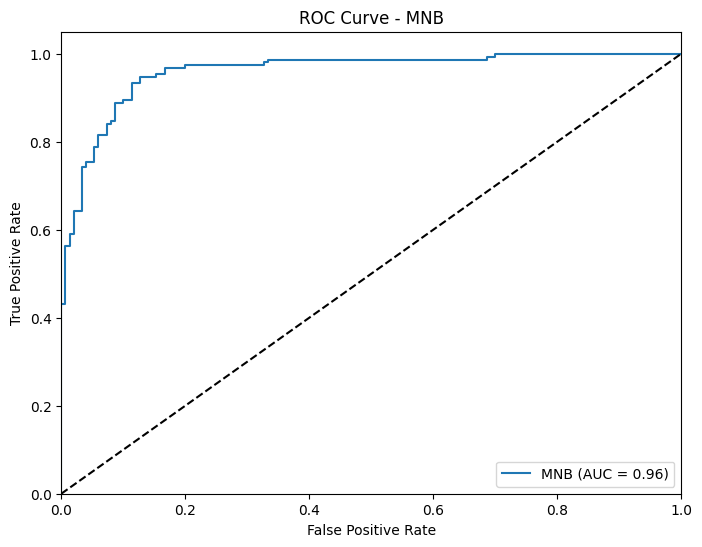

Metrics for LR:
Accuracy: 0.8770764119601329
Precision: 0.9453125
Recall: 0.8013245033112583
F1 Score: 0.8673835125448028
AUC: 0.9684326710816777
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89       150
           1       0.95      0.80      0.87       151

    accuracy                           0.88       301
   macro avg       0.89      0.88      0.88       301
weighted avg       0.89      0.88      0.88       301



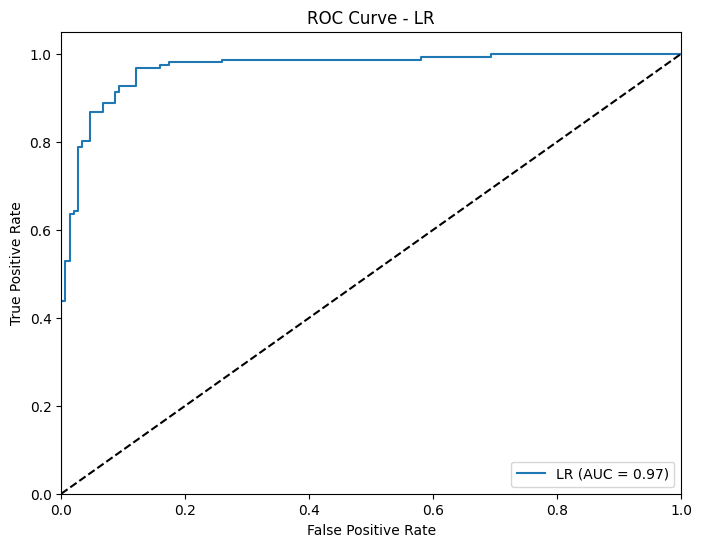

Metrics for RF:
Accuracy: 0.8903654485049833
Precision: 0.9538461538461539
Recall: 0.8211920529801324
F1 Score: 0.8825622775800712
AUC: 0.9725386313465784
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.96      0.90       150
           1       0.95      0.82      0.88       151

    accuracy                           0.89       301
   macro avg       0.90      0.89      0.89       301
weighted avg       0.90      0.89      0.89       301



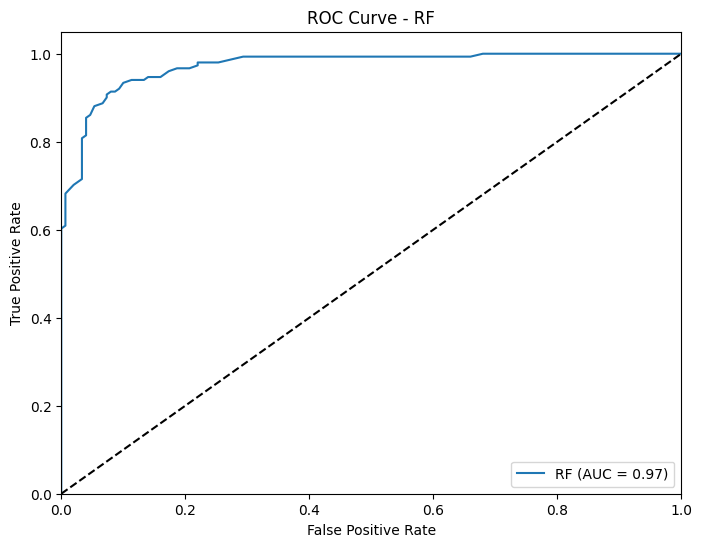

Metrics for KNN:
Accuracy: 0.8272425249169435
Precision: 0.7796610169491526
Recall: 0.9139072847682119
F1 Score: 0.8414634146341463
AUC: 0.9220971302428256
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.81       150
           1       0.78      0.91      0.84       151

    accuracy                           0.83       301
   macro avg       0.84      0.83      0.83       301
weighted avg       0.84      0.83      0.83       301



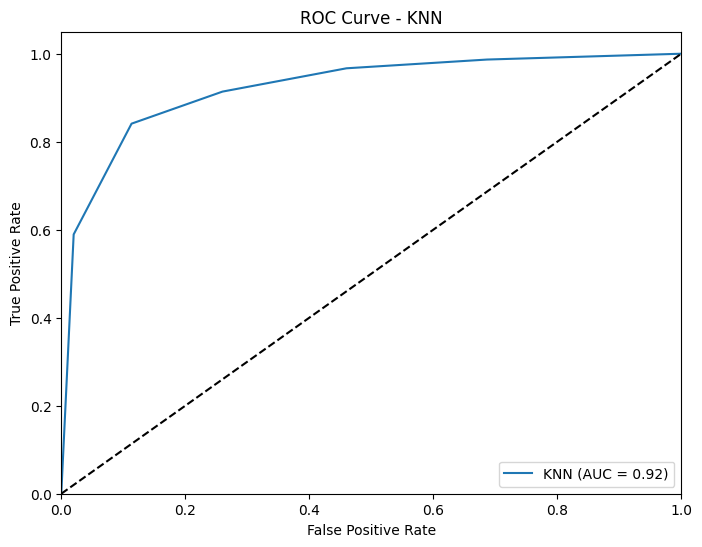

Metrics for SVM:
Accuracy: 0.893687707641196
Precision: 0.976
Recall: 0.8079470198675497
F1 Score: 0.8840579710144928
AUC: 0.9735099337748344
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       150
           1       0.98      0.81      0.88       151

    accuracy                           0.89       301
   macro avg       0.91      0.89      0.89       301
weighted avg       0.91      0.89      0.89       301



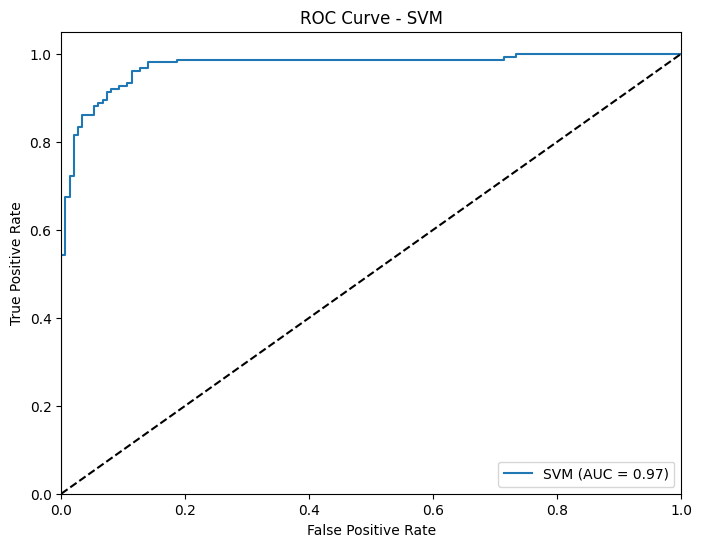

Metrics for Stacking Model:
Accuracy: 0.946843853820598
Precision: 0.9591836734693877
Recall: 0.9337748344370861
F1 Score: 0.9463087248322147
AUC: 0.9765783664459162
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       150
           1       0.96      0.93      0.95       151

    accuracy                           0.95       301
   macro avg       0.95      0.95      0.95       301
weighted avg       0.95      0.95      0.95       301



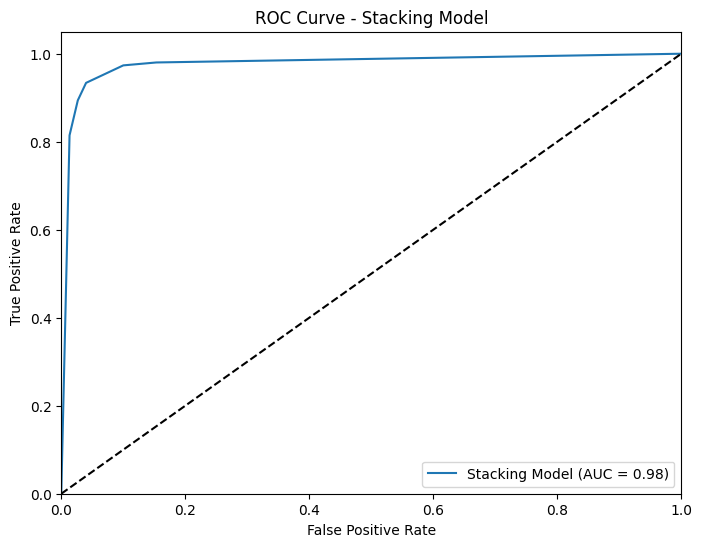

Comparison of Models:
                Accuracy Precision    Recall  F1 Score       AUC
MNB             0.813953   0.73399  0.986755  0.841808  0.959647
LR              0.877076  0.945312  0.801325  0.867384  0.968433
RF              0.890365  0.953846  0.821192  0.882562  0.972539
KNN             0.827243  0.779661  0.913907  0.841463  0.922097
SVM             0.893688     0.976  0.807947  0.884058   0.97351
Stacking Model  0.946844  0.959184  0.933775  0.946309  0.976578


In [12]:
base_names = ['MNB', 'LR', 'RF', 'KNN', 'SVM']
metrics_df = pd.DataFrame(index=base_names + ['Stacking Model'], columns=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])

vectorized_text = stack.named_steps['vectorizer'].transform(training_x)

# Evaluate base models
for model, name in  zip(stack.named_steps['stacking'].estimators_ , base_names):
    y_pred = model.predict(vectorized_text)
    y_prob = model.predict_proba(vectorized_text)[:, 1]  # Probability for positive class for ROC curve
    
    accuracy = accuracy_score(training_y, y_pred)
    precision = precision_score(training_y, y_pred)
    recall = recall_score(training_y, y_pred)
    f1 = f1_score(training_y, y_pred)
    auc = roc_auc_score(training_y, y_prob)

    print(f"Metrics for {name}:")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"AUC: {auc}")
    print(f"Classification Report:\n{classification_report(training_y, y_pred)}")

    # Store metrics in the DataFrame
    metrics_df.loc[name] = [accuracy, precision, recall, f1, auc]

    # ROC Curve
    fpr, tpr, _ = roc_curve(training_y, y_prob)
    roc_auc = roc_auc_score(training_y, y_prob)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {name}')
    plt.legend(loc="lower right")
    plt.show()


# Evaluate stacking model
stack_y_pred = stack.predict(training_x)
stack_y_prob = stack.predict_proba(training_x)[:, 1]  # Probability for positive class for ROC curve

stack_accuracy = accuracy_score(training_y, stack_y_pred)
stack_precision = precision_score(training_y, stack_y_pred)
stack_recall = recall_score(training_y, stack_y_pred)
stack_f1 = f1_score(training_y, stack_y_pred)
stack_auc = roc_auc_score(training_y, stack_y_prob)

print("Metrics for Stacking Model:")
print(f"Accuracy: {stack_accuracy}")
print(f"Precision: {stack_precision}")
print(f"Recall: {stack_recall}")
print(f"F1 Score: {stack_f1}")
print(f"AUC: {stack_auc}")
print(f"Classification Report:\n{classification_report(training_y, stack_y_pred)}")

# ROC Curve for stacking model
stack_fpr, stack_tpr, _ = roc_curve(training_y, stack_y_prob)
stack_roc_auc = roc_auc_score(training_y, stack_y_prob)

# Store stacking model metrics in the DataFrame
metrics_df.loc['Stacking Model'] = [stack_accuracy, stack_precision, stack_recall, stack_f1, stack_auc]


# Plot ROC Curve for stacking model
plt.figure(figsize=(8, 6))
plt.plot(stack_fpr, stack_tpr, label=f'Stacking Model (AUC = {stack_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Stacking Model')
plt.legend(loc="lower right")
plt.show()

# Display the comparison table
print("Comparison of Models:")
print(metrics_df)